# II. Evaluation: 평가 지표 정의 및 성능 평가

In [ ]:
# =========================================================
# 라이브러리 install 및 git clone, hugging face login
# =========================================================

# 1. 깃 클론 및 경로 이동 (Test Set 파일 확보)
!git clone https://github.com/jsjang0104/HUFS-LAI-ML-2025-2.git
%cd HUFS-LAI-ML-2025-2
print("✅ 깃 클론 및 경로 이동 완료.")

# 2. transformers와 datasets 재설치
# Colab 기본 numpy/torch와 충돌을 최소화하기 위해 강제 업그레이드 옵션은 제거합니다.
!pip install transformers==4.27.4 datasets -q
print("✅ transformers와 datasets 재설치 완료")

# 3. Hugging Face 로그인
from huggingface_hub import notebook_login
notebook_login()
print("✅ 허깅페이스 로그인 완료")

fatal: destination path 'HUFS-LAI-ML-2025-2' already exists and is not an empty directory.
/content/HUFS-LAI-ML-2025-2/HUFS-LAI-ML-2025-2
✅ 깃 클론 및 경로 이동 완료.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
✅ transformers와 datasets 재설치 완료


✅ 허깅페이스 로그인 완료


In [11]:
# =========================================================
# 라이브러리 import
# =========================================================
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
print("✅ 모든 라이브러리 import 완료")

✅ 모든 라이브러리 import 완료


In [12]:
# =========================================================
# 하이퍼파라미터, 경로 설정
# =========================================================
HF_MODEL_ID = "jsjang0104/book-genre-classifier-bert"
LABELS = ['Geschichte', 'Literatur', 'Sozialwissenschaften', 'Sprachwissenschaft']
NUM_CLASSES = len(LABELS)
MAX_LEN = 256 # training.ipynb와 동일
EVAL_BATCH_SIZE = 32 # training.ipynb와 동일
CONFIDENCE_THRESHOLD = 0.70 # 저확신 임계값 (0.0 ~ 1.0)
RANDOM_SEED = 42 # training.ipynb와 동일
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("✅ 하이퍼파라미터 및 경로 설정 완료")

✅ 하이퍼파라미터 및 경로 설정 완료


## 1. 평가 지표 정의

### 1-1. 평가 지표 정의
1. Accuracy (정확도)
  - 전체 예측 중 정확하게 분류된 비율
  - $(TP+TN) / (TP+TN+FP+FN)$
  - 모델의 전반적인 성능을 나타냄

2. Weighted Precision (정밀도)
  - 모델이 Positive라고 예측한 것 중 실제 Positive인 비율
  - $TP / (TP+FP)$
  - FP를 줄이는 것이 중요할 때
  - '어학'에서 클래스 불균형이 관찰되어 가중 평균 사용

3. Weighted Recall (재현율)
  - 실제 Positive인 것 중 모델이 Positive로 정확하게 예측한 비율
  - $TP / (TP+FN)$
  - False Negative (놓치는 것)를 줄이는 것이 중요할 때
  - '어학'에서 클래스 불균형이 관찰되어 가중 평균 사용

4. Weighted F1-score
  - Precision과 Recall의 조화 평균.
  - $2 \cdot (Precision \cdot Recall) / (Precision + Recall)$
  - Precision과 Recall의 균형을 나타내는 단일 지표
  - '어학'에서 클래스 불균형이 관찰되어 가중 평균 사용

5. Macro F1-score
  - 각 클래스별 F1-Score를 계산 후, 클래스 크기에 상관없이 단순 평균
  - 샘플 수가 적은 Minority Class(어학)의 성능이 모델의 최종 지표에 미치는 영향을 확대

### 1-2. Dataset 클래스 정의 (training.ipynb 파일에서 복원)

In [13]:
class BookReviewDataset(torch.utils.data.Dataset):
    def __init__(self, data_df, tokenizer, max_len, class_to_idx):
        self.texts = data_df['title'].tolist()
        self.labels = data_df['subject'].map(class_to_idx).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✅ BookReviewDataset 클래스 정의 완료.")

✅ BookReviewDataset 클래스 정의 완료.


### 1-3. 평가 지표 계산 코드

In [14]:
def calculate_metrics(y_true, y_pred):
    """
    Accuracy, Precision, Recall, F1-Score 계산
    Precision, Recall, F1-Score는 클래스별로 계산한 후,
    'weighted' 평균 (클래스 불균형을 고려) 사용
    """
    accuracy = accuracy_score(y_true, y_pred)

    # Weighted Average (샘플 수 가중) - 주요 지표
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )

    # Macro Average (단순 평균) - Minority
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )

    # 클래스별 F1-Score 확인
    _, _, f1_per_class, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )

    return {
        'accuracy': accuracy,
        'f1_weighted': f1_w,
        'f1_macro': f1_m,
        'precision_weighted': prec_w,
        'recall_weighted': rec_w,
        'f1_per_class': f1_per_class
    }
print("✅ Accuracy, Precision, Recall, F1-Score 계산 함수 정의 완료")

def evaluate_with_confidence(model, data_loader, device):
    """
    Test Set에 대한 예측 후
    실제 레이블, 예측 라벨, Softmax를 적용한 확률(Confidence) 반환
    """
    model.eval()
    y_true_list = []
    y_pred_list = []
    probs_list = []

    progress_bar = tqdm(data_loader, desc="Evaluating Test Set")

    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # 1. Logits에 Softmax 적용하여 확률(Confidence) 계산
            probs = F.softmax(outputs.logits, dim=1)

            # 2. 가장 높은 확률의 인덱스를 최종 예측 라벨로 결정
            _, preds = torch.max(probs, dim=1)

            # 결과 저장
            y_true_list.extend(labels.cpu().numpy())
            y_pred_list.extend(preds.cpu().numpy())
            probs_list.extend(probs.cpu().numpy())

    return np.array(y_true_list), np.array(y_pred_list), np.array(probs_list)
print("✅ Confidence 계산 함수 정의 완료")


def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Confusion Matrix를 계산하고 시각화
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()
print("✅ Confiusion Matrix 시각화 함수 정의 완료")


def analyze_low_confidence(df_test, y_true, y_pred, y_probs, class_names, threshold):
    """
    Low Confidence로 예측된 샘플 분석 후
    후보 별 label 및 확률 출력
    """

    # 1. 최대 확률 추출
    max_probs = np.max(y_probs, axis=1)
    low_confidence_indices_array = np.where(max_probs < threshold)[0]

    print(f"--- 저확신 예측 분석 (Threshold < {threshold:.2f}) ---")
    print(f"총 {len(y_probs)}개 중 {len(low_confidence_indices_array)}개가 저확신 분류입니다.")

    if len(low_confidence_indices_array) == 0:
        print("모든 예측이 지정된 임계값보다 높은 확신도를 보였습니다.")
        return

    # 저확신 샘플 중 최대 10개만 출력하여 분석
    for i, idx in enumerate(low_confidence_indices_array[:10]):

        # 텍스트 데이터 가져오기
        text_data = df_test.iloc[idx]['title']

        actual_label = class_names[y_true[idx]]
        predicted_label = class_names[y_pred[idx]]

        # 확률 높은 순서대로 인덱스 정렬
        ranked_indices = np.argsort(y_probs[idx])[::-1]

        print(f"[Index: {idx}] (실제: {actual_label}, 예측: {predicted_label}, Conf: {max_probs[idx]:.4f})")
        print(f"  |-- Title: {text_data}")
        print("  |-- Class별 순위:")

        # 후보 출력
        for rank, j in enumerate(ranked_indices[:4]):
            label_name = class_names[j]
            prob = y_probs[idx][j]
            # 예측이 오답 표시 (T/F)
            is_correct = " (O)" if j == y_true[idx] else " (X)"
            print(f"  |   {rank+1}위: {label_name} ({prob:.4f}){is_correct}")
print("✅ Low Confidence 샘플 분석 함수 정의 완료")

✅ Accuracy, Precision, Recall, F1-Score 계산 함수 정의 완료
✅ Confidence 계산 함수 정의 완료
✅ Confiusion Matrix 시각화 함수 정의 완료
✅ Low Confidence 샘플 분석 함수 정의 완료


## 2. 모델 로드 및 데이터 준비

In [15]:
# 1. 모델 및 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_ID)
model = AutoModelForSequenceClassification.from_pretrained(HF_MODEL_ID, num_labels=NUM_CLASSES)
model.to(device)
print(f"✅ Hugging Face Hub에서 모델 '{HF_MODEL_ID}' 로드 완료.")

# 2. Evaluation Dataset 로드
DATA_PATH = '/content/HUFS-LAI-ML-2025-2/submissions/202400420/assignment5/eval_dataset/test_data.csv'
df_test = pd.read_csv(DATA_PATH)
df_test = df_test.reset_index(drop=True)
print(f"✅ test dataset 로드 완료.")

# 3. Evaluation  Dataset 클래스 분포 확인 (투명성)
def get_class_distribution(df):
    distribution = df['subject'].value_counts(normalize=True).mul(100).rename('Percentage')
    return distribution

# Evaluation Dataset 출력
test_dist = get_class_distribution(df_test)
distribution_summary = pd.DataFrame({'Test': test_dist}).sort_index().round(2)

print("\n--- Test Dataset 클래스 분포 비교 (단위: %) ---")
print(distribution_summary)


# 4. DataLoader 생성
NUM_CLASSES = len(LABELS)
class_to_idx = {label: i for i, label in enumerate(LABELS)}
test_dataset = BookReviewDataset(
    df_test,
    tokenizer,
    MAX_LEN,
    class_to_idx
)

test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False
)

print(f"Test Set의 총 샘플 수: {len(df_test)}, 총 배치 수: {len(test_loader)}")

✅ Hugging Face Hub에서 모델 'jsjang0104/book-genre-classifier-bert' 로드 완료.
✅ test dataset 로드 완료.

--- Test Dataset 클래스 분포 비교 (단위: %) ---
                       Test
subject                    
Geschichte            33.23
Literatur             31.51
Sozialwissenschaften  26.95
Sprachwissenschaft     8.31
Test Set의 총 샘플 수: 2853, 총 배치 수: 90


## 3. 최종 evaluation

### 3-1. 최종 평가 및 분석

Evaluating Test Set:   0%|          | 0/90 [00:00<?, ?it/s]

=================== 최종 성능 평가 결과 ===================
Accuracy (전체 정확도): 0.7291
F1-Score (Weighted - 샘플 가중치): 0.7284
F1-Score (Macro - 단순 평균): 0.7262
---
클래스별 F1-Score:
  - Geschichte: 0.6868
  - Literatur: 0.7348
  - Sozialwissenschaften: 0.7800
  - Sprachwissenschaft: 0.7032


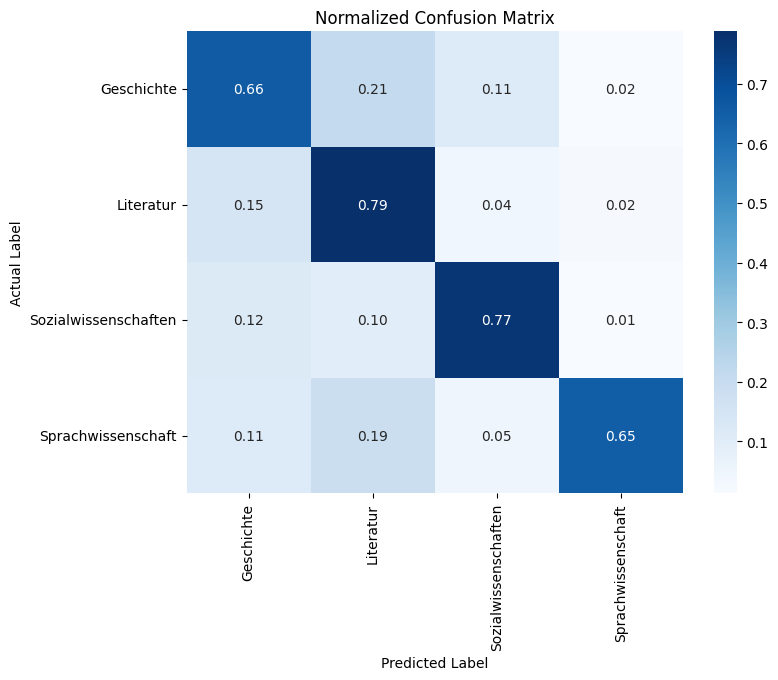

--- 저확신 예측 분석 (Threshold < 0.70) ---
총 2853개 중 852개가 저확신 분류입니다.
[Index: 3] (실제: Geschichte, 예측: Geschichte, Conf: 0.6445)
  |-- Title: die westmächte und polen im 18. jahrhundert
  |-- Class별 순위:
  |   1위: Geschichte (0.6445) (O)
  |   2위: Sozialwissenschaften (0.3334) (X)
  |   3위: Literatur (0.0142) (X)
  |   4위: Sprachwissenschaft (0.0078) (X)
[Index: 4] (실제: Sprachwissenschaft, 예측: Geschichte, Conf: 0.6826)
  |-- Title: notes of a journey on the upper mekong siam.
  |-- Class별 순위:
  |   1위: Geschichte (0.6826) (X)
  |   2위: Sprachwissenschaft (0.2820) (O)
  |   3위: Sozialwissenschaften (0.0177) (X)
  |   4위: Literatur (0.0177) (X)
[Index: 6] (실제: Literatur, 예측: Literatur, Conf: 0.5341)
  |-- Title: durch aufklärung zur wahren menschlichkeit
  |-- Class별 순위:
  |   1위: Literatur (0.5341) (O)
  |   2위: Geschichte (0.2380) (X)
  |   3위: Sozialwissenschaften (0.1480) (X)
  |   4위: Sprachwissenschaft (0.0799) (X)
[Index: 13] (실제: Literatur, 예측: Literatur, Conf: 0.5269)
  |-- Title: kraft

In [16]:
# 1. 평가 실행 및 확률(Confidence) 추출
y_true, y_pred, y_probs = evaluate_with_confidence(model, test_loader, device)

# 2. 최종 지표 계산
final_metrics = calculate_metrics(y_true, y_pred)

print("=================== 최종 성능 평가 결과 ===================")
print(f"Accuracy (전체 정확도): {final_metrics['accuracy']:.4f}")
print(f"F1-Score (Weighted - 샘플 가중치): {final_metrics['f1_weighted']:.4f}")
print(f"F1-Score (Macro - 단순 평균): {final_metrics['f1_macro']:.4f}")
print("---")
print("클래스별 F1-Score:")
for i, class_name in enumerate(LABELS):
    print(f"  - {class_name}: {final_metrics['f1_per_class'][i]:.4f}")

# 3. 클래스별 성능 분석: Confusion Matrix 시각화
plot_confusion_matrix(y_true, y_pred, LABELS)

# 4. 저확신 분류 후보 분석
analyze_low_confidence(df_test, y_true, y_pred, y_probs, LABELS, CONFIDENCE_THRESHOLD)

### 3-2. 최종 지표 출력 테이블 생성 (Markdown)

In [17]:
print("\n" + "="*50)
print("         README.md용 종합 성능 표 (Markdown)")
print("="*50)
print("| Metric | Average Type | Score |")
print("| :--- | :--- | :--- |")
print(f"| Accuracy | Overall | {final_metrics['accuracy']:.4f} |")
print(f"| F1-Score | Weighted | {final_metrics['f1_weighted']:.4f} |")
print(f"| F1-Score | Macro | {final_metrics['f1_macro']:.4f} |")
print(f"| Precision | Weighted | {final_metrics['precision_weighted']:.4f} |")
print(f"| Recall | Weighted | {final_metrics['recall_weighted']:.4f} |")


         README.md용 종합 성능 표 (Markdown)
| Metric | Average Type | Score |
| :--- | :--- | :--- |
| Accuracy | Overall | 0.7291 |
| F1-Score | Weighted | 0.7284 |
| F1-Score | Macro | 0.7262 |
| Precision | Weighted | 0.7314 |
| Recall | Weighted | 0.7291 |
